In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from utils.load_data import load_split
from utils.ml_training import plot_classification_metrics, plot_model_sizes, plot_training_times, run_ml_experiments
from utils.types import FeatureVector_float32, RGBImage_uint8


In [2]:
train_images, train_labels = load_split("data/train/", library="pil")
len(train_images), train_images[0].shape, train_labels.shape


Loading FAKE images: 100%|██████████| 50000/50000 [00:27<00:00, 1798.57it/s]


(100000, (32, 32, 3), (100000,))

In [3]:
test_images, test_labels = load_split("data/test/", library="pil")
len(test_images), test_images[0].shape, test_labels.shape


Loading FAKE images: 100%|██████████| 10000/10000 [00:06<00:00, 1457.49it/s]


(20000, (32, 32, 3), (20000,))

In [4]:
# Matches the color histogram setup validated in test.ipynb
COLOR_HIST_BINS = 16


In [5]:
def extract_color_hist(img: RGBImage_uint8) -> FeatureVector_float32:
    """Concatenate per-channel normalized histograms."""
    feats: list[float] = []
    for channel_id in range(3):
        channel = img[..., channel_id].ravel()
        hist, _ = np.histogram(channel, bins=COLOR_HIST_BINS, range=(0, 255), density=True)
        feats.extend(hist)
    return np.array(feats, dtype=np.float32)


In [6]:
extract_color_hist(train_images[0]).shape


(48,)

In [7]:
color_features_list_train: list[FeatureVector_float32] = [
    extract_color_hist(img) for img in tqdm(train_images, desc="Extracting color histograms from train images")
]
color_features_list_test: list[FeatureVector_float32] = [
    extract_color_hist(img) for img in tqdm(test_images, desc="Extracting color histograms from test images")
]


Extracting color histograms from test images: 100%|██████████| 20000/20000 [00:03<00:00, 6617.27it/s]


In [8]:
real_color_hist: FeatureVector_float32 = np.array(color_features_list_train)[:50000].mean(axis=0)
fake_color_hist: FeatureVector_float32 = np.array(color_features_list_train)[50000:].mean(axis=0)


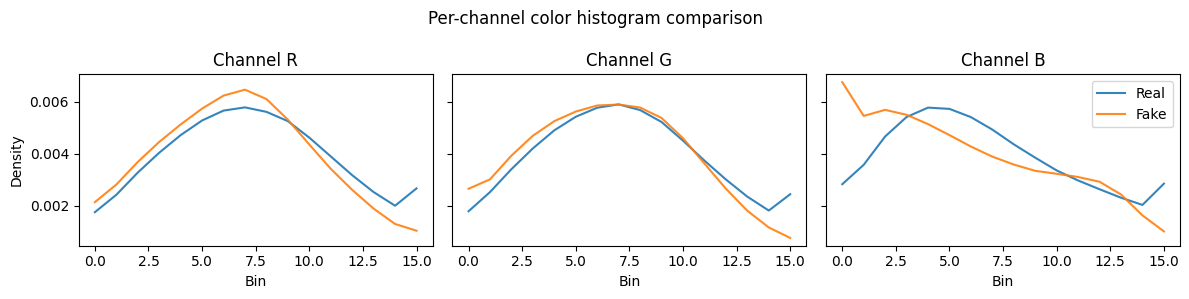

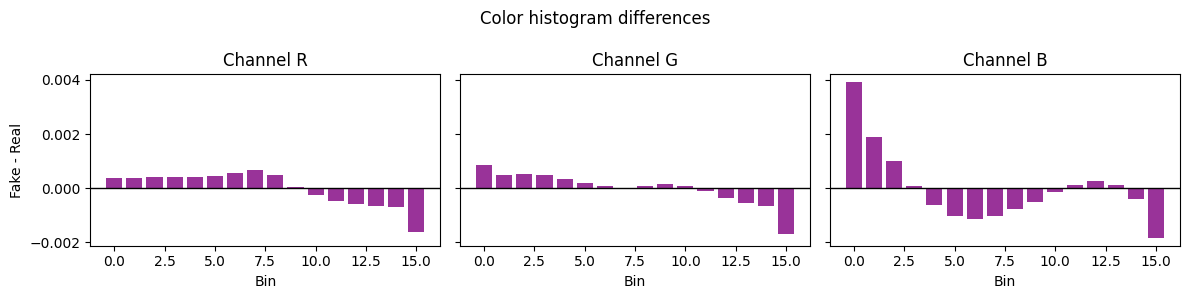

In [9]:
def _reshape_hist(vec: FeatureVector_float32) -> np.ndarray:
    return vec.reshape(3, COLOR_HIST_BINS)


def plot_color_histograms(real_hist: FeatureVector_float32, fake_hist: FeatureVector_float32) -> None:
    channels = ["R", "G", "B"]
    real = _reshape_hist(real_hist)
    fake = _reshape_hist(fake_hist)
    fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
    for idx, ax in enumerate(axes):
        ax.plot(real[idx], label="Real", alpha=0.9)
        ax.plot(fake[idx], label="Fake", alpha=0.9)
        ax.set_title(f"Channel {channels[idx]}")
        ax.set_xlabel("Bin")
    axes[0].set_ylabel("Density")
    axes[-1].legend()
    fig.suptitle("Per-channel color histogram comparison")
    fig.tight_layout()
    plt.show()


def plot_color_hist_diff(real_hist: FeatureVector_float32, fake_hist: FeatureVector_float32) -> None:
    diff = _reshape_hist(fake_hist - real_hist)
    fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
    channels = ["R", "G", "B"]
    for idx, ax in enumerate(axes):
        ax.bar(np.arange(COLOR_HIST_BINS), diff[idx], color="purple", alpha=0.8)
        ax.axhline(0, color="black", linewidth=1)
        ax.set_title(f"Channel {channels[idx]}")
        ax.set_xlabel("Bin")
    axes[0].set_ylabel("Fake - Real")
    fig.suptitle("Color histogram differences")
    fig.tight_layout()
    plt.show()


plot_color_histograms(real_color_hist, fake_color_hist)
plot_color_hist_diff(real_color_hist, fake_color_hist)


In [10]:
X_train = np.array(color_features_list_train)
y_train = train_labels
X_test = np.array(color_features_list_test)
y_test = test_labels


In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((100000, 48), (20000, 48), (100000,), (20000,))

In [12]:
X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype


(dtype('float32'), dtype('float32'), dtype('uint8'), dtype('uint8'))

In [13]:
rng = np.random.RandomState(42)
shuffle_indices = rng.permutation(len(X_train))
X_train = X_train[shuffle_indices]
y_train = y_train[shuffle_indices]


In [14]:
path_output = Path("outputs/color_classification_results.json")
results = run_ml_experiments(X_train, y_train, X_test, y_test, path_output)



GaussianNB:
Training time (sec): 0.03
              precision    recall  f1-score   support

        Real     0.7135    0.3546    0.4737     10000
        Fake     0.5706    0.8576    0.6853     10000

    accuracy                         0.6061     20000
   macro avg     0.6420    0.6061    0.5795     20000
weighted avg     0.6420    0.6061    0.5795     20000

Model size (joblib): 0.001 MB

KNN:
Training time (sec): 0.00
              precision    recall  f1-score   support

        Real     0.7484    0.6989    0.7228     10000
        Fake     0.7176    0.7651    0.7406     10000

    accuracy                         0.7320     20000
   macro avg     0.7330    0.7320    0.7317     20000
weighted avg     0.7330    0.7320    0.7317     20000

Model size (joblib): 5.929 MB

LogisticRegression:
Training time (sec): 9.88
              precision    recall  f1-score   support

        Real     0.6486    0.7214    0.6831     10000
        Fake     0.6862    0.6092    0.6454     10000

    

d:\AT82.08-AI-Generated-Image-Classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


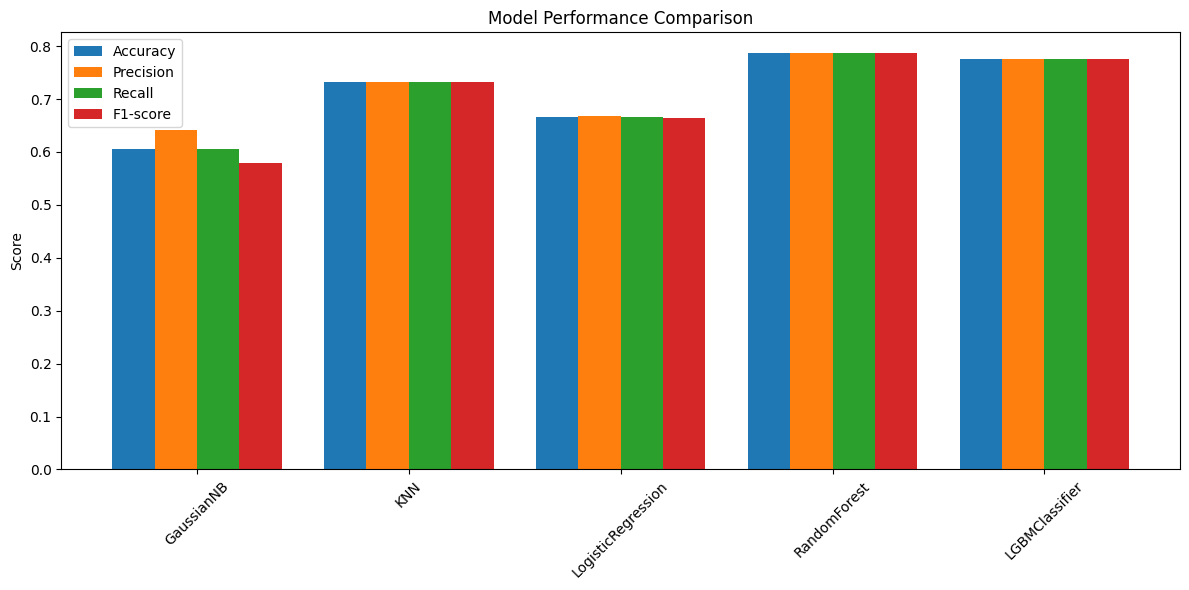

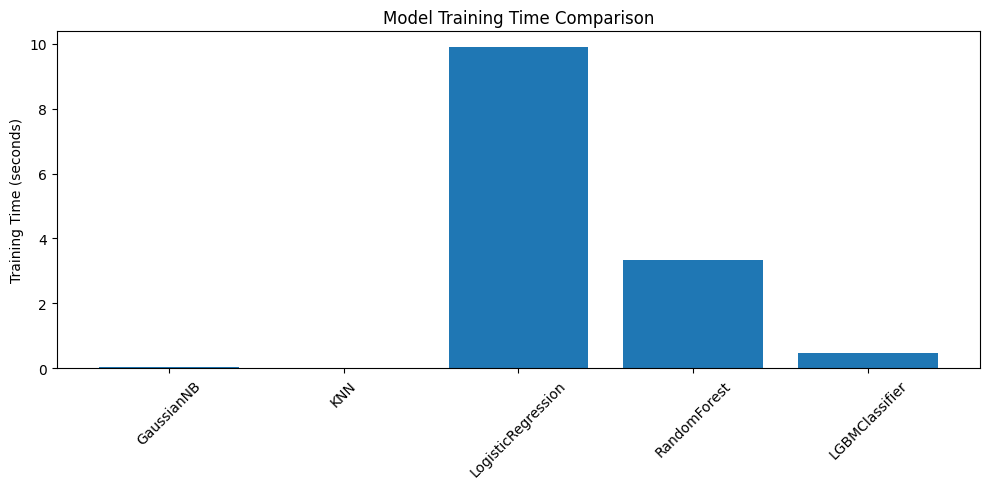

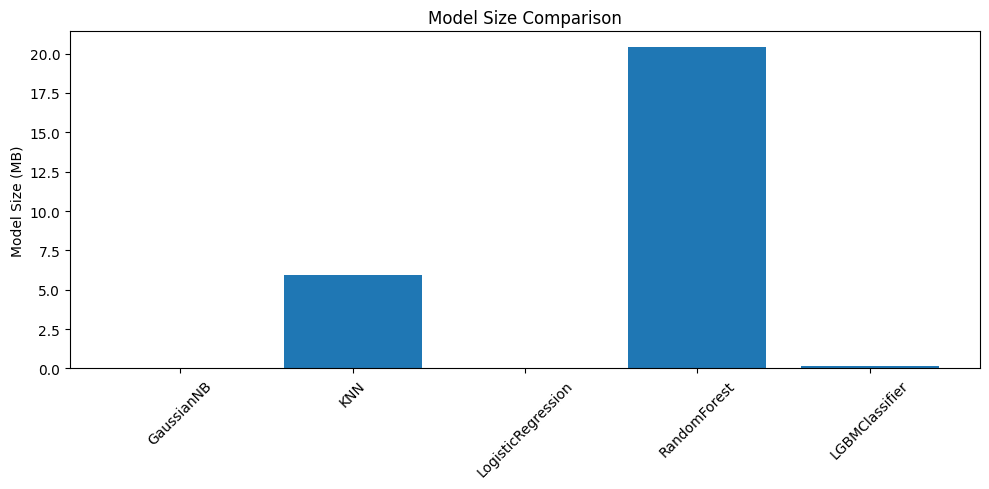

In [15]:
plot_classification_metrics(results)
plot_training_times(results)
plot_model_sizes(results)
